In [2]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import re

In [3]:
ROOT_PATH = Path('../..').resolve()
DATA_PATH = ROOT_PATH/'data/cmrc2018'

In [4]:
with open(DATA_PATH/'cmrc2018_train.json', 'r') as f:
    train_samples = json.load(f)

In [5]:
train_samples[0]

{'context_id': 'TRAIN_186',
 'context_text': '范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机。1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，同年年底被擢升为枢机；2009年2月离世。范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南神父带到河内继续其学业。范廷颂于1940年在河内大修道院完成神学学业。范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务。1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民。1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范廷颂仍然留在河内。翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕。1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天主的爱」。由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作。范廷颂除了面对战争、贫困、被当局迫害天主教会等问题外，也秘密恢复修院、创建女修会团体等。1990年，教宗若望保禄二世在同年6月18日擢升范廷颂为天主教河内总教区宗座署理以填补该教区总主教的空缺。1994年3月23日，范廷颂被教宗若望保禄二世擢升为天主教河内总教区总主教并兼天主教谅山教区宗座署理；同年11月26日，若望保禄二世擢升范廷颂为枢机。范廷颂在1995年至2001年期间出任天主教越南主教团主席。2003年4月26日，教宗若望保禄二世任命天主教谅山教区兼天主教高平教区吴光杰主教为天主教河内总教区署理主教；及至2005年2月19日，范廷颂因获批辞去总主教职务而荣休；吴光杰同日真除天主教河内总教区总主教职务。范廷颂于2009年2月22日清晨在河内离世，享年89岁；其葬礼于同月26日上午在天主教河内总教区总主教座堂举行。',
 'qas': [{'query_id': 'TRAIN_186_QUERY_0',
   'query_text': '范廷颂是什么时候被任为主教的？',
   'answers': ['1963年']},
  {'query_id': 'TRAIN_186_QUERY

In [6]:
num_q = 0
num_a = 0
for sample in train_samples:
    num_q += len(sample['qas'])
    for q in sample['qas']:
        num_a += len(q['answers'])
num_q, num_a

(10142, 10142)

In [7]:
iter = re.finditer('[。]', '你好。我好。大家好。')
[x.span() for x in iter]

[(2, 3), (5, 6), (9, 10)]

In [8]:
def find_correct_sentence_span(a: str, sentence: str):
    # 找出答案所在的句子。有的答案可能横跨多个句子，因此先找出答案span在context中的位置，
    # 再从左右两边选取最近的句号，作为答案所在的句子。 
    try:
        start, end = next(re.finditer(re.escape(a), sentence)).span()   # re.escape将字符串中的特殊符号视为字符而非正则表达式中的符号
        # print(start, end)
    except:
        # 在context中找不到答案
        return None
    period_idx = [x.start() for x in re.finditer('[。]', sentence)]
    # print(period_idx)
    if len(period_idx) == 0:    # 没有句号，直接返回整个context
        return 0, len(sentence)
    
    if period_idx[0] > start:   # 答案span前面没有句号，说明句子开头在context首部
        head_p = 0
    else:   # 从context中最前的句号向后查找离答案最近的句号
        head_p = period_idx[0]
        for i in period_idx:
            if i < start:
                head_p = i + 1
            else:
                break

    if period_idx[-1] < end:    
        tail_p = end      # 答案span后边没有句号，说明句子结尾在context尾部
    else:   # 从context中最后的句号向前查找离答案最近的句号
        tail_p = period_idx[-1] 
        for j in period_idx[::-1]:
            if j >= end-1:
                tail_p = j
            else:
                break
    return head_p, tail_p

In [9]:
print(find_correct_sentence_span('有毛病', '你这人有毛病哈哈有病的'))
print(find_correct_sentence_span('有毛病', '你这人有毛病。哈哈。有病的'))
print(find_correct_sentence_span('有毛病', '呵呵。你这人有毛病。'))

(0, 11)
(0, 6)
(3, 9)


In [10]:
def build_AS_dataset(samples):
    df = {'query_id': [], 'query': [], 'context_id': [], 'answer': [], 'label': []}
    # 对于每个问题和答案span，将答案span所在的句子作为正样本，其他句子作为负样本
    for i, sample in tqdm(enumerate(samples)):
        sample['context_text'] = sample['context_text'].strip()
        for q in sample['qas']:
            q['query_text'] = q['query_text'].strip()
            for a in q['answers']:
                # 有的答案在原文中是逗号结尾，但答案却改成了句号结尾，把句号去掉以保证能在原文中找到该答案span
                span = find_correct_sentence_span(str(a).strip('。'), sample['context_text'])
                # 如果能在context中找到相应的句子
                if span is not None:
                    # 正样本
                    df['query_id'].append(q['query_id'])
                    df['query'].append(q['query_text'])
                    df['context_id'].append(sample['context_id'])
                    df['answer'].append(sample['context_text'][span[0]: span[1]].strip())
                    df['label'].append(1)
                    # 负样本
                    neg_sents = re.split('。', sample['context_text'][0: span[0] if span[0] > 0 else 0]) + \
                                        re.split('。', sample['context_text'][span[1]+1:])  # 从正样本答案句的前面和后边提取负样本答案
                    for neg_sent in neg_sents:
                        if len(neg_sent) > 0:   # 不知道为什么会出现长度为0的负样本
                            df['query_id'].append(q['query_id'])
                            df['query'].append(q['query_text'])
                            df['context_id'].append(sample['context_id'])
                            df['answer'].append(neg_sent)
                            df['label'].append(0)
                else:
                    pass
                    # print('haha')
                    # print(f'No. {i}-th sample, {q}')
                    # print(a)
                    # print(sample['context_text'])
    return pd.DataFrame(data=df)

In [11]:
train_df = build_AS_dataset(train_samples)

2403it [00:01, 1587.58it/s]


In [21]:
train_df = train_df.drop_duplicates(['query', 'answer'])   # 去掉一些重复样本（不知道为啥出现）
train_df

,query_id,query,context_id,answer,label
0,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，...,1
1,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机,0
2,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南...,0
3,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,范廷颂于1940年在河内大修道院完成神学学业,0
4,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务,0
5,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民,0
6,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范...,0
7,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕,0
8,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天...,0
9,TRAIN_186_QUERY_0,范廷颂是什么时候被任为主教的？,TRAIN_186,由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作,0


In [13]:
def show_length_histogram(df):
    q_lengths = train_df['query'].apply(func=lambda x: len(x)).sort_values()
    a_lengths = train_df['answer'].apply(func=lambda x: len(x)).sort_values()
    plt.subplot(211)
    plt.hist(q_lengths[:int(len(q_lengths)*0.99)], bins=100)
    plt.show()
    plt.subplot(212)
    plt.hist(a_lengths[:int(len(a_lengths)*0.99)], bins=100)
    plt.show()

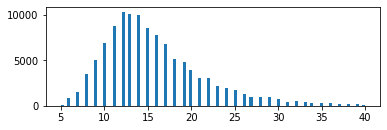

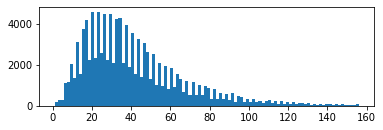

In [14]:
show_length_histogram(train_df)

In [15]:
train_df.to_csv(DATA_PATH/'cmrc2018_train.csv', index=False)

In [16]:
with open(DATA_PATH/'cmrc2018_dev.json', 'r') as f:
    dev_samples = json.load(f)

In [28]:
dev_df = build_AS_dataset(dev_samples)

848it [00:00, 1238.32it/s]


In [30]:
dev_df = dev_df.drop_duplicates(subset=['query', 'answer'])     # 验证集中有的问题可以有几个答案，但是一般这些答案都在同一个句子，因此可以去重
dev_df

,query_id,query,context_id,answer,label
0,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,《战国无双3》（）是由光荣和ω-force开发的战国无双系列的正统第三续作,1
1,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,本作以三大故事为主轴，分别是以武田信玄等人为主的《关东三国志》，织田信长等人为主的《战国三杰...,0
2,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,此部份专门介绍角色，欲知武器情报、奥义字或擅长攻击类型等，请至战国无双系列1.由于乡里大辅先...,0
3,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,从猛将传 and Z开始,0
4,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,2.战国无双 编年史的原创男女主角亦有专属声优,0
5,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,此模式是任天堂游戏谜之村雨城改编的新增模式,0
6,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,本作中共有20张战场地图（不含村雨城），后来发行的猛将传再新增3张战场地图,0
7,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,但游戏内战役数量繁多，部分地图会有兼用的状况，战役虚实则是以光荣发行的2本「战国无双3 人物...,0
8,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,（注：前方加☆者为猛将传新增关卡及地图,0
9,DEV_0_QUERY_0,《战国无双3》是由哪两个公司合作开发的？,DEV_0,）合并本篇和猛将传的内容，村雨城模式剔除，战国史模式可直接游玩,0


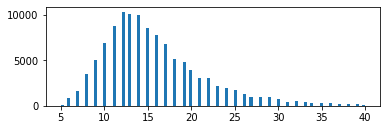

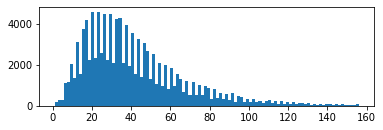

In [31]:
show_length_histogram(dev_df)

In [32]:
dev_df.to_csv(DATA_PATH/'cmrc2018_dev.csv', index=False)